<a href="https://colab.research.google.com/github/bhushanrajs/sciml_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP STRUCTURAL MINDS SciML PROJECT

Texas has the largest number of beam-slab bridges in the country according to National Bridge Inventory (FHWA 2022). Railings or crash barriers are provided on either side of deck for crash protection and to contain the colliding vehicle within the bridge. In recent times, there is a necessity to provide heavier and taller railings or sound walls for higher crash rating or to reduce noise in bridges crossing urban residential areas. These heavy railings and sound walls weight two to three times that of normal railings. The Texas Department of Transportaion (TxDOT) recommends to distribute railing dead loads to two or three girders for normal railings (TxDOT 2022). But this recommendation is not applicable in case of heavy railings and sound walls. So designers need to perform finite element analysis in such cases.

The project team has performed parametric Finite Element (FE) analyses for various geometries of Pre-Stressed Concrete (PSC) I-girder straight bridges. The bending moments and bearing reactions are of primary importance in structural design of these bridges. There are 8 standard PSC I-girders used in Texas. The span-to-depth ratios typically range between 15 to 30. All these bridges have 4 girder lines with girder center-to-center spacing varying from 6 to 12 ft. The minimum width of overhang varies from half of girder top flange width (zero overhang from edge of girder) to a maximum of 3.5 ft. Deck slab was assumed to be of uniform thickness throughout the entire width of the bridge.Deck slab thickness values of 8.5 in. and 12 in. were used in the models. The concrete grade for the deck and girders were assumed to be 4 ksi. and 7 ksi., respectively. A railing load of 1000 lb/ft. was applied on the left edge of the deck distributed over the width of the railing along the full length of the bridge.

The bending moment and bearing reactions are dependent on the stiffness properties of the bridge. Hence, they are dependent on the material and geometric properties of the bridge. In this project, we intend to develop a Machine Learning (ML) model that can predict the design forces for any given PSC I-girder bridge geometry. The raw data is imported from github using pandas.

ML models work well on normalized data, therefore the bending moments and reactions were normalized before training. Line analysis was performed for each girder with the entire weight of the railing assumed to be applied along the centerline of the girder. Since, only simply-supported bridges were analyzed the results for line analysis could be computed easily by closed-form solutions. The ratio of force obtained from FE analysis to the line analysis is defined as distribution factor. These factors indicated the proportion of load transferred to each girder, thereby the designer can optimize the design by choosing appropriate geometry. The distribution factors calculated from bending moments is called as Moment Distribution Factor ($df_M$) and that from the bearing reactions is called as Shear Distribution Factor ($df_V$). These distribution factors are the output variables for the ML model. Hence, there are 8 outputs for each 4-girder bridge system. The variation of these distribution factors for G1 (left exterior) and G2 (first left-interior) girders are plotted below. These girders were of importance because they are close to the railing load.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/sciml_project/main/analysis_data.csv')
df = df.dropna()
print(df)

                            Model Name Girder Type  Nb     L    S  w_oh  ts_U  \
0       Tx28-L_45-Nb_4-S_60-O_15-ts_85        Tx28   4   540   72    18   8.5   
1      Tx28-L_45-Nb_4-S_60-O_15-ts_100        Tx28   4   540   72    18  10.0   
2       Tx28-L_45-Nb_4-S_60-O_20-ts_85        Tx28   4   540   72    24   8.5   
3      Tx28-L_45-Nb_4-S_60-O_20-ts_100        Tx28   4   540   72    24  10.0   
4       Tx28-L_45-Nb_4-S_60-O_25-ts_85        Tx28   4   540   72    30   8.5   
...                                ...         ...  ..   ...  ...   ...   ...   
2060   Tx84-L_160-Nb_4-S_80-O_35-ts_85        Tx84   4  1920   96    42   8.5   
2061   Tx84-L_160-Nb_4-S_90-O_30-ts_85        Tx84   4  1920  108    36   8.5   
2062   Tx84-L_160-Nb_4-S_90-O_35-ts_85        Tx84   4  1920  108    42   8.5   
2063  Tx84-L_160-Nb_4-S_100-O_25-ts_85        Tx84   4  1920  120    30   8.5   
2064  Tx84-L_160-Nb_4-S_100-O_35-ts_85        Tx84   4  1920  120    42   8.5   

      ts_O  fc_deck  fc_gir

In [ ]:
tx_girders = {'Tx28' : {'D' : 28.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 6.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx34' : {'D' : 34.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 12.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx40' : {'D' : 40.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 18.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx46' : {'D' : 46.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 22.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx54' : {'D' : 54.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 30.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx62' : {'D' : 62.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 37.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx70' : {'D' : 70.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 45.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx84' : {'D' : 84.0, 'b1' : 58.0, 'b2' : 8.0, 'b3' : 38.0, 'b4' : 3.0, 'b5' : 3.0, 'd1' : 4.0, 'd2' : 3.5, 'd3' : 3.0, 'd4' : 55.75, 'd5' : 3.0, 'd6' : 6.0, 'd7' : 8.75}
              }

# bridge geometry data
L = df['L']/12 # span length in ft.
S = df['S']/12 # girder spacing in ft.
w_oh = df['w_oh']/12 # overhang width in ft.
ts = df['ts_U']/12 # thickness of overhang in ft.
girder = df['Girder Type']
girder_depth = []
for _, girder_type in girder.items():
  girder_depth.append(tx_girders[girder_type]['D'])
df['D'] = girder_depth

# intensity of railing dead load in kip/ft
b_rail = df['b_rail_left'] # width of railing
q_rail = (df['q_rail_left'] * b_rail * 12)/1000

# max bending moment in exterior girder G1 & interior girder G2 in kip-ft
bm1 = df['G1 - max_bm']/(1000*12)
bm2 = df['G2 - max_bm']/(1000*12)
bm3 = df['G3 - max_bm']/(1000*12)
bm4 = df['G4 - max_bm']/(1000*12)

# reaction in girders G1 & G2 in kip. (only A1 taken due to symmetry)
r1 = df['G1-A1-Y']/1000
r2 = df['G2-A1-Y']/1000
r3 = df['G3-A1-Y']/1000
r4 = df['G4-A1-Y']/1000

# line analysis with full railing load assumed to be applied on a girder
bm_line = q_rail * (L - 2*9/12)**2 / 8
r_line = q_rail * L / 2


# normalizing bending moments with respect to line analysis
n_bm1 = bm1 / bm_line
n_bm2 = bm2 / bm_line
n_bm3 = bm3 / bm_line
n_bm4 = bm4 / bm_line

# normalizing vertical reactions with respect to line analysis
n_r1 = r1 / r_line
n_r2 = r2 / r_line
n_r3 = r3 / r_line
n_r4 = r4 / r_line


df['n_bm1'] = n_bm1
df['n_bm2'] = n_bm2
df['n_bm3'] = n_bm3
df['n_bm4'] = n_bm4
df['n_r1'] = n_r1
df['n_r2'] = n_r2
df['n_r3'] = n_r3
df['n_r4'] = n_r4

In [ ]:
print(n_bm1 + n_bm2 + n_bm3 + n_bm4)
print(n_r1 + n_r2 + n_r3 + n_r4)

0       0.990695
1       0.986348
2       0.998870
3       0.995075
4       1.007073
          ...   
2060    1.039071
2061    1.045995
2062    1.054395
2063    1.048749
2064    1.063360
Length: 2065, dtype: float64
0       1.000001
1       1.000001
2       1.000001
3       1.000001
4       1.000001
          ...   
2060    1.000001
2061    1.000001
2062    1.000001
2063    1.000001
2064    1.000001
Length: 2065, dtype: float64


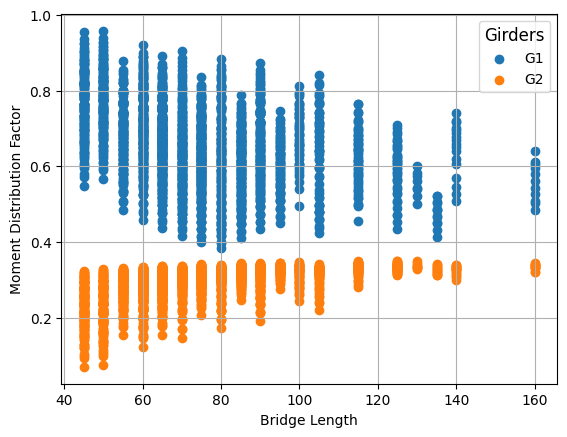

In [ ]:
# Plot moment distribution factors
plt.scatter(L,n_bm1, label = "G1")
plt.scatter(L,n_bm2, label = "G2")

# axis labels
plt.xlabel(r'Bridge Length')
plt.ylabel(r'Moment Distribution Factor')

# display a legend, set its title
leg = plt.legend()
leg.set_title('Girders', prop={'size':12})

plt.grid() # show a grid

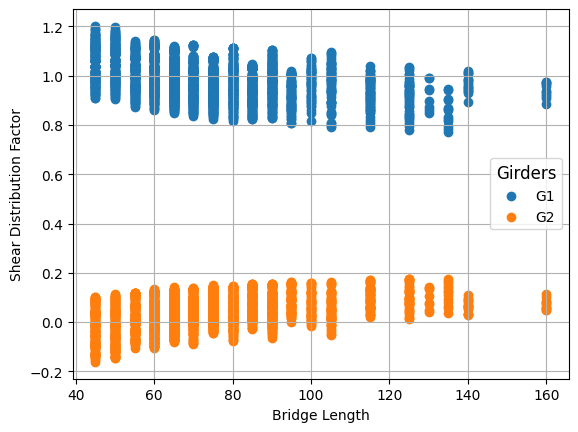

In [ ]:
# Plot shear distribution factors
plt.scatter(L,n_r1, label = "G1")
plt.scatter(L,n_r2, label = "G2")

# axis labels
plt.xlabel(r'Bridge Length')
plt.ylabel(r'Shear Distribution Factor')

# display a legend, set its title
leg = plt.legend()
leg.set_title('Girders', prop={'size':12})

plt.grid() # show a grid

In [ ]:
df_G1 = df[['L', 'S', 'w_oh', 'ts_U','D', 'n_bm1','n_bm2', 'n_bm3','n_bm4','n_r1', 'n_r2','n_r3', 'n_r4']]
df_G1.head()

,L,S,w_oh,ts_U,D,n_bm1,n_bm2,n_bm3,n_bm4,n_r1,n_r2,n_r3,n_r4
0,540,72,18,8.5,28.0,0.570854,0.319484,0.099727,0.000631,0.908724,0.096629,0.039131,-0.044483
1,540,72,18,10.0,28.0,0.549410,0.323670,0.112149,0.001120,0.908414,0.101636,0.050613,-0.060662
2,540,72,24,8.5,28.0,0.602907,0.306543,0.088845,0.000576,0.973940,0.036811,0.036875,-0.047625
3,540,72,24,10.0,28.0,0.579155,0.313099,0.101768,0.001053,0.973641,0.043130,0.047993,-0.064763
4,540,72,30,8.5,28.0,0.634685,0.293845,0.078021,0.000522,1.038466,-0.021503,0.033653,-0.050614


In [ ]:
X = df_G1.copy(deep=True)
y = df_G1[['n_bm1','n_bm2', 'n_bm3','n_bm4','n_r1', 'n_r2','n_r3', 'n_r4']]

tensor_y = torch.tensor(y.values, dtype=torch.float32)

X_train_target, X_val_test_target, y_train, y_val_test = train_test_split(X, y, test_size=0.2)
X_test_target, X_val_target, y_test, y_val = train_test_split(X_val_test_target, y_val_test, test_size=0.2)

In [ ]:
X_train = X_train_target.drop(['n_bm1','n_bm2', 'n_bm3','n_bm4','n_r1', 'n_r2','n_r3', 'n_r4'], axis=1)
X_test = X_test_target.drop(['n_bm1','n_bm2', 'n_bm3','n_bm4','n_r1', 'n_r2','n_r3', 'n_r4'], axis=1)
X_val = X_val_target.drop(['n_bm1','n_bm2', 'n_bm3','n_bm4','n_r1', 'n_r2','n_r3', 'n_r4'], axis=1)

tensor_y_train = torch.tensor(y_train.values, dtype=torch.float32)
tensor_y_val = torch.tensor(y_val.values, dtype=torch.float32)
tensor_y_test = torch.tensor(y_test.values, dtype=torch.float32)

tensor_X_train = torch.tensor(X_train.values, dtype=torch.float32)
tensor_X_test = torch.tensor(X_test.values, dtype=torch.float32)
tensor_X_val = torch.tensor(X_val.values, dtype=torch.float32)


In [ ]:
model = nn.Sequential(
    nn.Linear(5, 32),  # Input layer with 6 features and 64 units
    nn.ReLU(),        # Activation function (you can choose other activation functions)
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 8)   # Output layer with 64 units and 2 output units
)

# Training
optimizer = optim.Adam(model.parameters())
losses = []
epochs = 5000
for epoch in tqdm(range(epochs), desc='Model training progress'):
    y_pred = model(tensor_X_train)

    # Define the loss function for each output
    loss_fn_output = nn.MSELoss()
    total_loss = loss_fn_output(y_pred, tensor_y_train)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    losses.append(total_loss.item())

Model training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

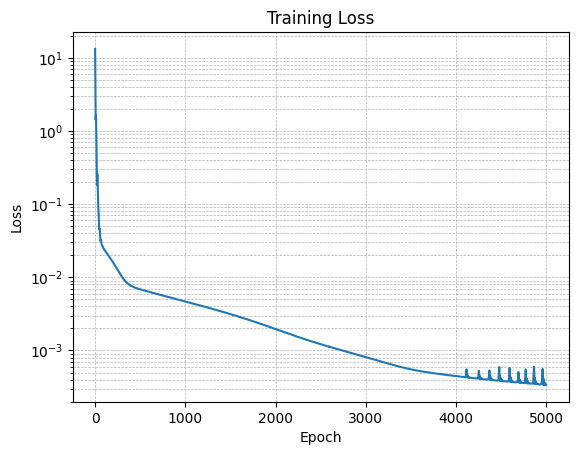

Test loss is: 0.00033895435626618564


In [ ]:
# Plot the loss on a semilog scale
plt.figure()
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

print(f"Test loss is: {total_loss}")

In [ ]:
y_pred_test = model(tensor_X_test)
loss_test = loss_fn_output(y_pred_test, tensor_y_test)

print(f"Test loss is: {loss_test}")

Test loss is: 0.00036640491452999413
